# Modeling

In [112]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.combine import SMOTEENN

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [113]:
# Load data
train = pd.read_csv('feat_train.csv')
test = pd.read_csv('feat_test.csv')
spray = pd.read_csv('feat_spray.csv')

#### Balance Classes

Since our target variable only makes up for 5% of the data, we will need to artificially balance the classes so that our models perform better. We want to use a combination of under and over sampling, so we will use the SMOTE method to accomplish this. 

In [114]:
# Define X and y
X = train.drop('WnvPresent', axis = 1)
y = train['WnvPresent']

In [115]:
# Convert Year and Month to Dummies
X = pd.get_dummies(X, columns = ['Year','Month'])

In [116]:
# Use SMOTE method to balance classes
sme = SMOTEENN()
X_res, y_res = sme.fit_sample(X, y)

In [117]:
# Check class balance 
pd.Series(y_res).value_counts(normalize = True)

1    0.504328
0    0.495672
dtype: float64

With the balanced data, the baseline accuracy score to beat is 50%

#### Logistic Regression

In [118]:
# Train test split and standardize data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [119]:
# Fit model and accuracy score
logreg = LogisticRegression()
model_logreg = logreg.fit(X_train, y_train)
model_logreg.score(X_train, y_train), model_logreg.score(X_test, y_test)

(0.8162568991470146, 0.8232992173389524)

In [120]:
# Evaluate model with AUC-ROC score
y_score = model_logreg.predict(X_test)
metrics.roc_auc_score(y_test, y_score)

0.8226552146136201

In [121]:
# Gridsearch on logistic regression model above
lr_params = {'penalty':['l1', 'l2'], 
             'C': [0.2, 0.3, 0.35, 0.5]}
gs = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gs.fit(X_train, y_train)

# Results 
gs.best_score_, gs.best_params_

(0.8156547917711992, {'C': 0.3, 'penalty': 'l1'})

In [122]:
# Gridsearch test accuracy score
gs.score(X_test, y_test)

0.8239012642986153

In [123]:
# Evaluate gridsearched model with AUC-ROC score
y_score = gs.predict(X_test)
metrics.roc_auc_score(y_test, y_score)

0.8232758120691706

Gridsearching did not seem to improve the AUC-ROC score. Neither model was overfit. 

In [124]:
# Determine top predictors in model 
coefs = pd.DataFrame(model_logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs['coef'] = np.exp(coefs['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head()

,coef
Month_8,2.330046
Year_2013,2.095916
Tavg,1.613067
Month_9,1.607329
Day,1.465599


In [130]:
model_logreg.predict_proba(X_test)

array([[0.0054405 , 0.9945595 ],
       [0.12653552, 0.87346448],
       [0.41995349, 0.58004651],
       ...,
       [0.95065439, 0.04934561],
       [0.99698481, 0.00301519],
       [0.0105466 , 0.9894534 ]])

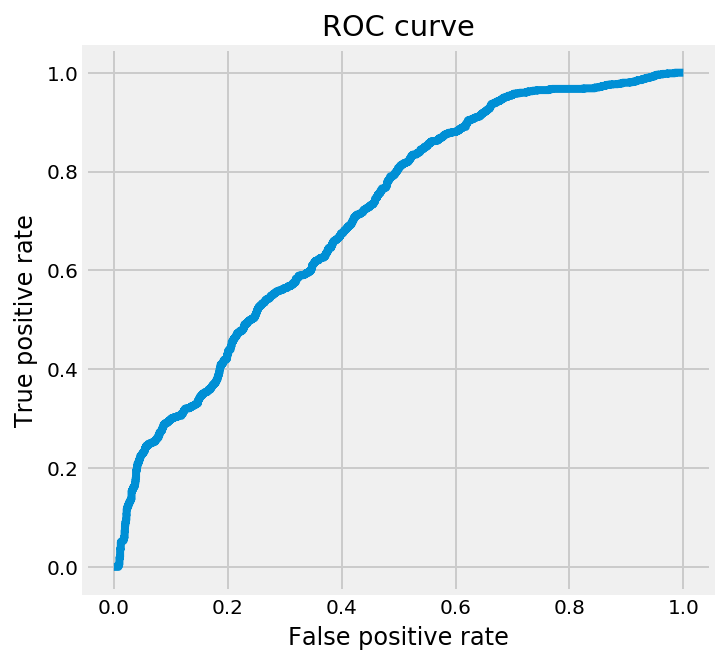

In [133]:
# ROC Plot 
y_probs = model_logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');